In [2]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import MazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper


object_env = make_maze_env(
    seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64), generate_new_maze_on_reset=True
)
q_hat = ManhattanQHat(object_env)

def make_maze_search_tree(env) -> SearchTree:
    return SearchTree(env, extract_state=MazeState.extract_state)

meta_env = MetaEnv(object_env, q_hat, make_maze_search_tree, max_tree_size=10)

env = TFPyEnvironment(GymWrapper(meta_env))


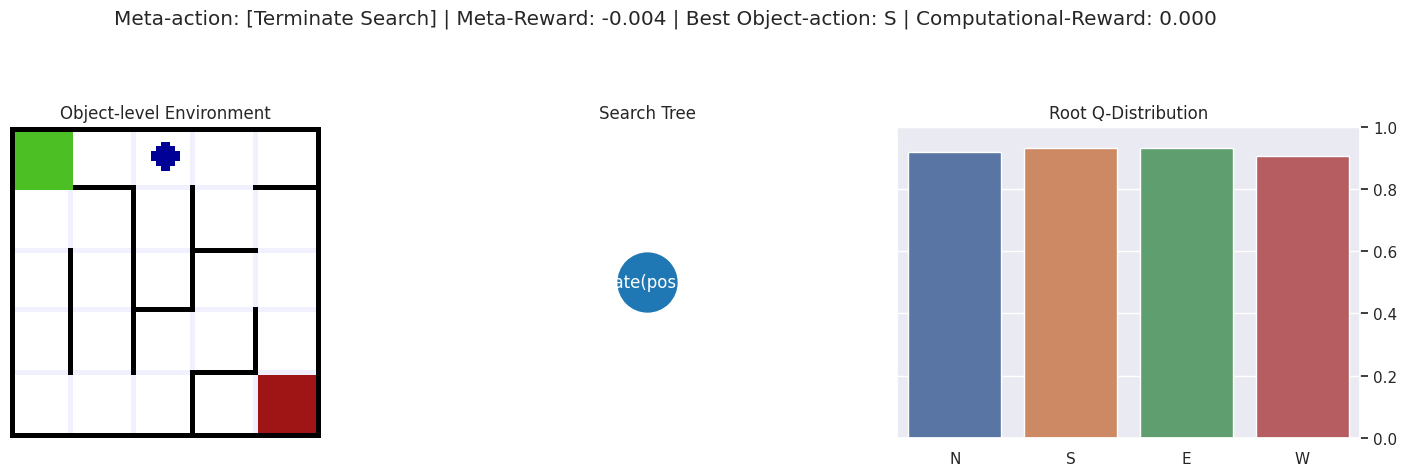

In [15]:
meta_env.step(0)
meta_env.step(0)
meta_env.render(plt_show=True)
meta_env.reset();

In [ ]:
meta_env.render(plt_show=True)

In [2]:
def mask_invalid_action_constraint_splitter(observation):
    return observation['search_tree_tokens'], observation['valid_action_mask']


from mlrl.meta.search_q_model import SearchQModel

import tensorflow as tf
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.specs import tensor_spec


# weights_path = './runs/dqn_agent/simple_single_grid_dqn-16638260065752182/model'
weights_path = './q_net.h5'

q_net = SearchQModel()
q_net.load_weights(weights_path)

optimizer = tf.keras.optimizers.Adam(learning_rate=0)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=sequential.Sequential([q_net]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter,
    train_step_counter=train_step_counter
)

agent.initialize()

INFO:tensorflow:Assets written to: ram://6908ab2e-9fe6-4ee2-abcc-7cb307a8ab88/assets


INFO:tensorflow:Assets written to: ram://6908ab2e-9fe6-4ee2-abcc-7cb307a8ab88/assets


In [5]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

embed_mp4(create_policy_eval_video(agent.policy, env, max_steps=30))

In [39]:
x = env.current_time_step().observation['search_tree_tokens']
search_q_model = SearchQModel()
search_q_model(x)

<tf.Tensor: shape=(1, 41), dtype=float32, numpy=
array([[-0.03295209, -0.15766887, -0.17016986, -0.11118837, -0.14050004,
        -0.03295209, -0.03295209, -0.03295209, -0.03295209, -0.03295209,
        -0.03295209, -0.03295209, -0.03295209, -0.03295209, -0.03295209,
        -0.03295209, -0.03295209, -0.03295209, -0.03295209, -0.03295209,
        -0.03295209, -0.03295209, -0.03295209, -0.03295209, -0.03295209,
        -0.03295209, -0.03295209, -0.03295209, -0.03295209, -0.03295209,
        -0.03295209, -0.03295209, -0.03295209, -0.03295209, -0.03295209,
        -0.03295209, -0.03295209, -0.03295209, -0.03295209, -0.03295209,
        -0.03295209]], dtype=float32)>

In [11]:
search_q_model.q_network.summary()

Model: "q_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 10, 192)              3648      
                                                                 
 reshape (Reshape)           (1, 40, 48)               0         
                                                                 
 prepend_terminate_token (Pr  (1, 41, 48)              0         
 ependTerminateToken)                                            
                                                                 
 transformer (Transformer)   (1, 41, 48)               11200     
                                                                 
 transformer_1 (Transformer)  (1, 41, 48)              11200     
                                                                 
 dense_1 (Dense)             (1, 41, 1)                49        
                                                         

In [98]:
agent.policy.action(env.current_time_step())

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

In [99]:
random_policy = random_tf_policy.RandomTFPolicy(
    env.time_step_spec(),
    env.action_spec(),
    observation_and_action_constraint_splitter=agent._observation_and_action_constraint_splitter)

TypeError: Image data of dtype object cannot be converted to float

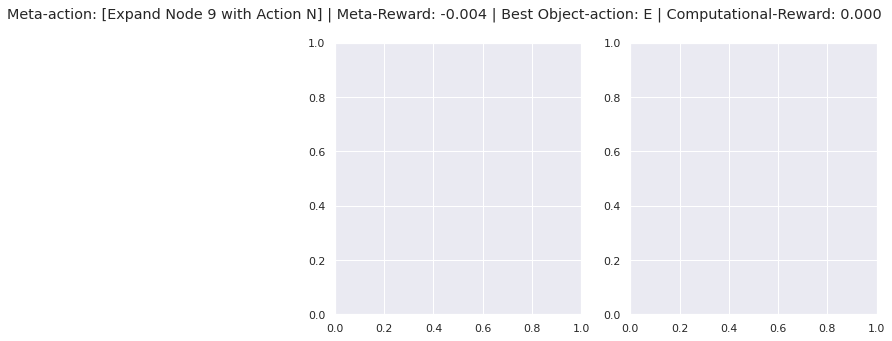

In [105]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

embed_mp4(create_policy_eval_video(random_policy, eval_env))

In [16]:
embed_mp4(create_policy_eval_video(agent.policy, eval_env))

In [102]:
from mlrl.run import compute_return_stats

compute_return_stats(env, random_policy)

-0.11245788

In [103]:
compute_return_stats(env, agent.policy)

-0.13000005

In [107]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)


def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(env, random_policy, replay_buffer, initial_collect_steps)

In [108]:
iter(replay_buffer.as_dataset()).next()

(Trajectory(
 {'action': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
  'discount': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  'next_step_type': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
  'observation': {'search_tree_tokens': <tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,
          1.   ,  0.   ],
        [ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   , -0.004,  1.   ,
          1.   ,  1.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ],
        [ 0.   ,  0.   ,

In [109]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': {'search_tree_tokens': TensorSpec(shape=(64, 2, 10, 18), dtype=tf.float32, name=None),
                 'valid_action_mask': TensorSpec(shape=(64, 2, 41), dtype=tf.int32, name=None)},
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.


step = 3200: loss = 8.431306923739612e-05
step = 3400: loss = 3.4982995202881284e-06
step = 3600: loss = 4.36356094724033e-06
step = 3800: loss = 8.59367219163687e-07
step = 4000: loss = 4.177253686066251e-06
Failed to create evaluation video: display Surface quit
step = 4000: Average Return = 0.40903589129447937
step = 4200: loss = 9.245689398085233e-06
step = 4400: loss = 3.196725083398633e-05
step = 4600: loss = 1.017621616483666e-05
step = 4800: loss = 2.9400493076536804e-05
step = 5000: loss = 1.5338946468546055e-05
Failed to create evaluation video: display Surface quit
step = 5000: Average Return = 0.9906290769577026
step = 5200: loss = 9.166878044197802e-06
step = 5400: loss = 1.0893189028138295e-05
step = 5600: loss = 5.730499651690479e-06
step = 5800: loss = 3.176169047947042e-05
step = 6000: loss = 1.1064019417972304e-05
Failed to create evaluation video: display Surface quit
step = 6000: Average Return = -0.3808193504810333
step = 6200: loss = 1.1077781891799532e-05
step = 

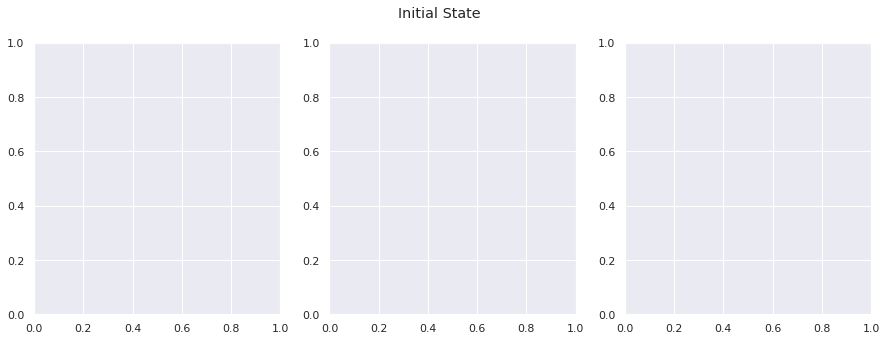

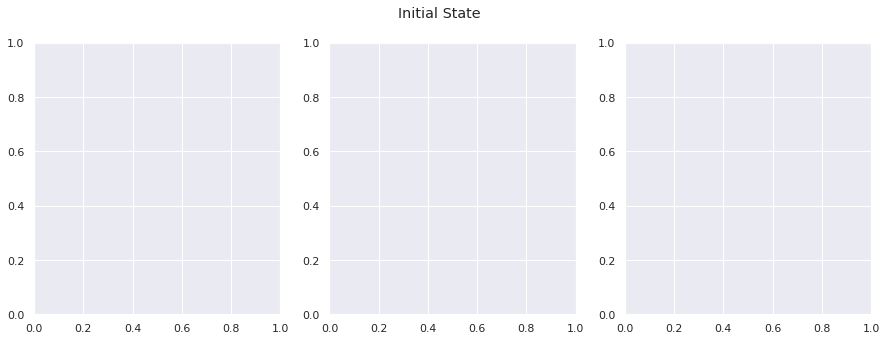

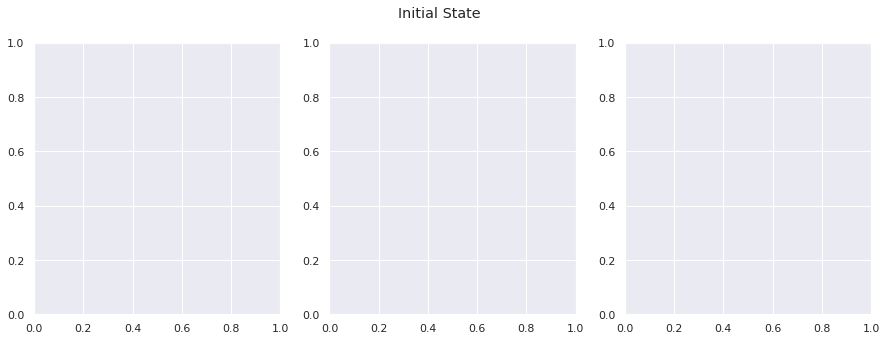

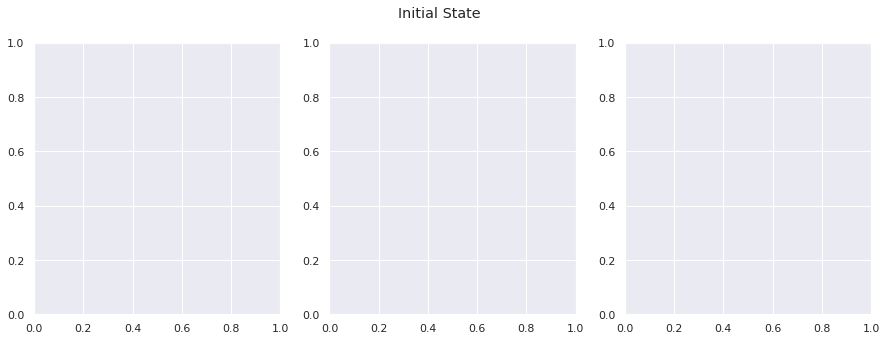

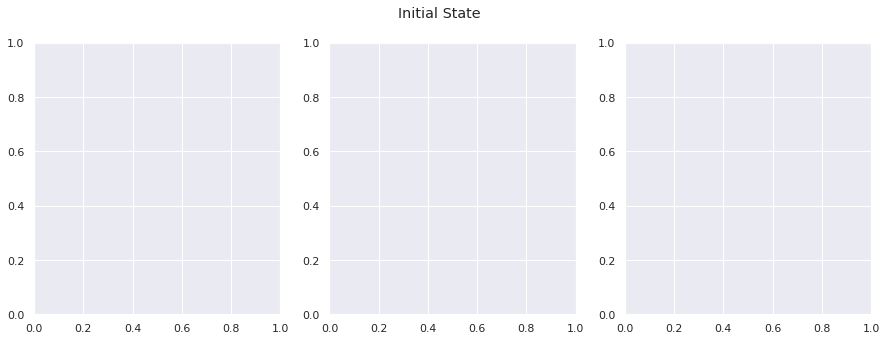

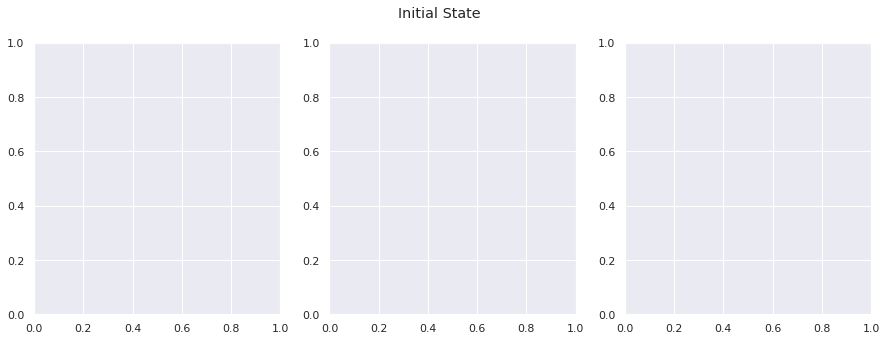

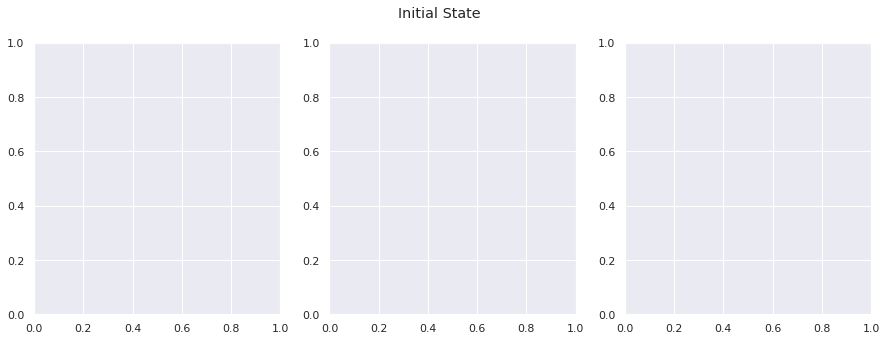

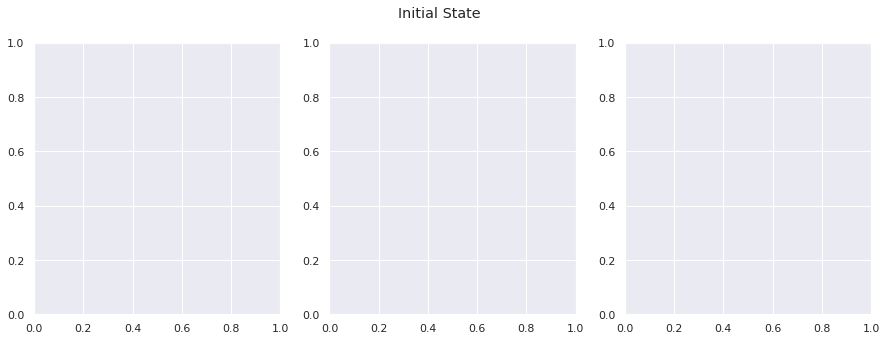

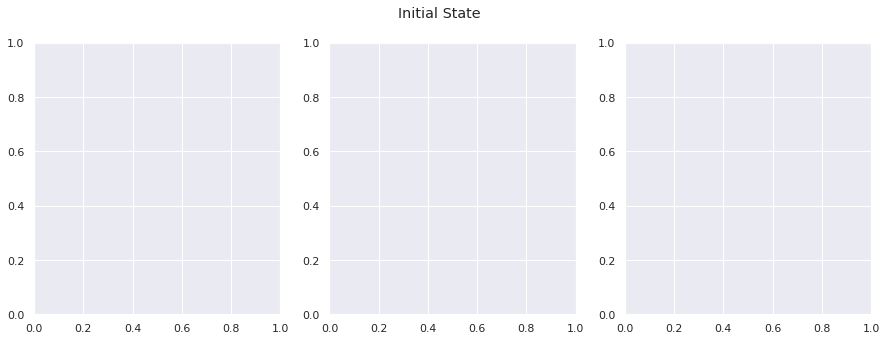

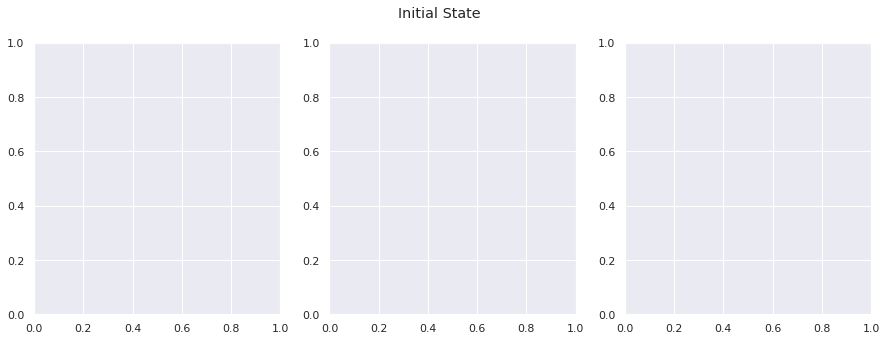

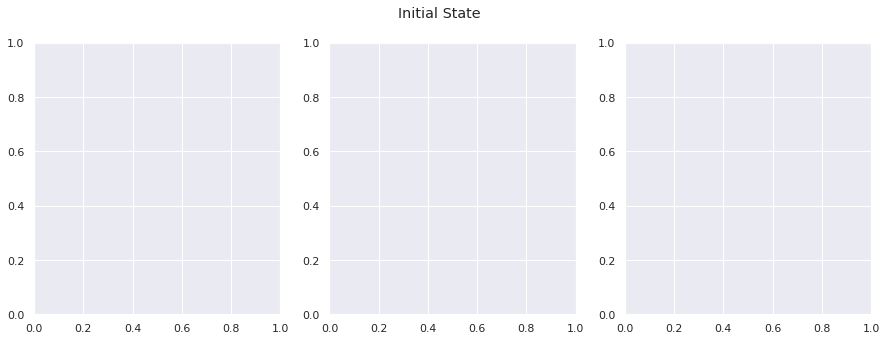

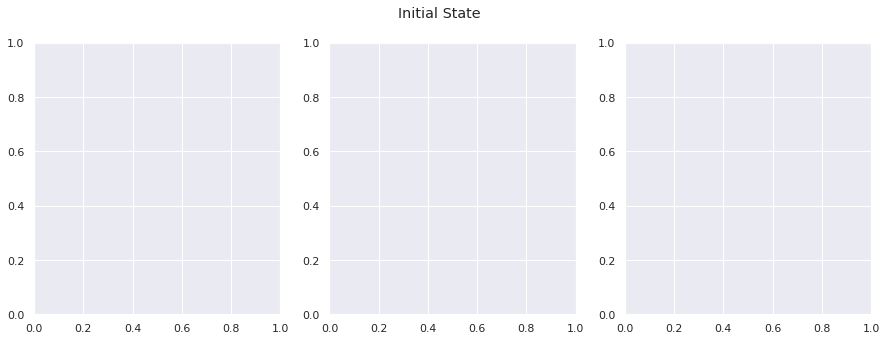

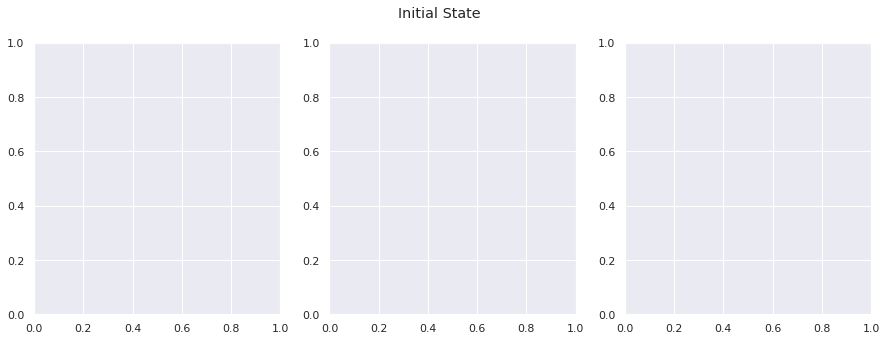

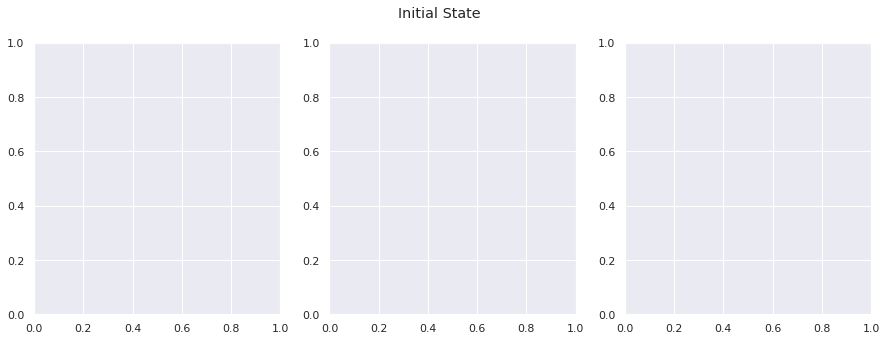

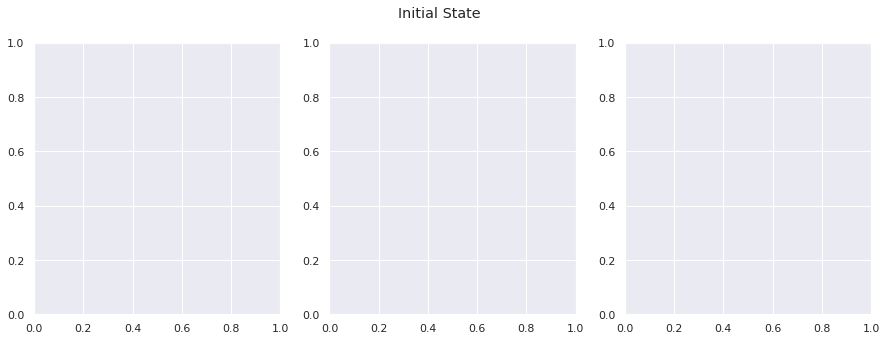

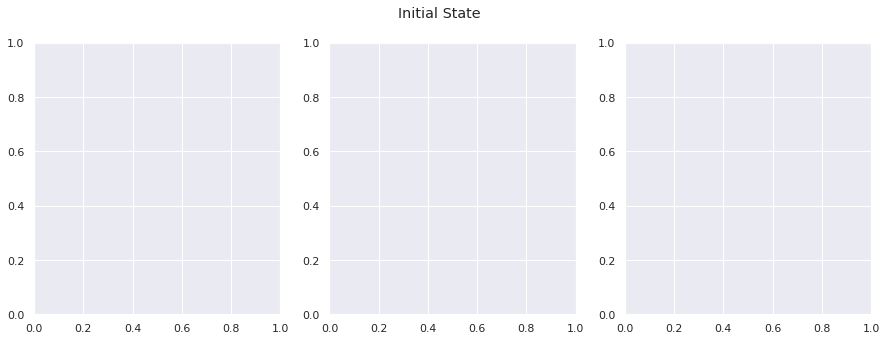

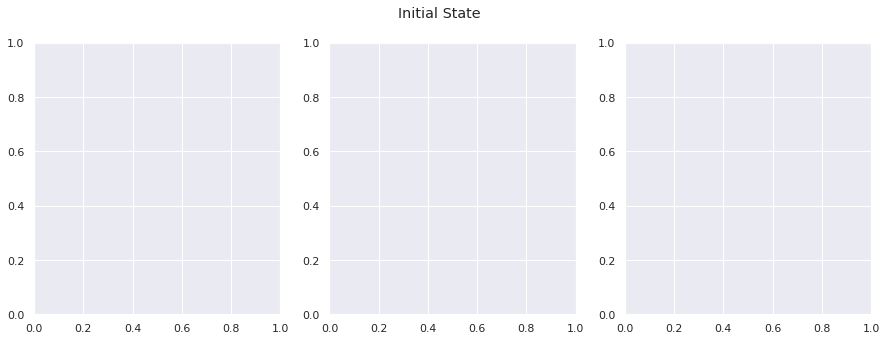

In [120]:
try:
  while iteration < num_iterations:

    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % env_reset_interval == 0:
      env.reset()

    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, agent.policy, num_episodes=1)

      try:
        eval_object_env = make_maze_env(
            seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64)
        )
        eval_meta_env = MetaEnv(eval_object_env, q_hat, make_maze_search_tree, max_tree_size=10)
        eval_env = TFPyEnvironment(GymWrapper(eval_meta_env))

        create_policy_eval_video(agent.policy, eval_env, max_steps=180, filename=f'videos/eval_video_step_{step}.mp4')
        print(f'Evaluation video saved to: videos/eval_video_step_{step}.mp4')

      except Exception as e:
        print('Failed to create evaluation video:', e)

      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      returns.append(avg_return)
    
    iteration += 1

except KeyboardInterrupt:
  print('Training interrupted.')

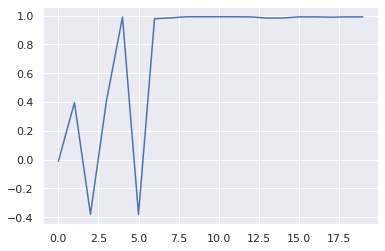

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

plt.plot(list(range(len(returns))), returns);

In [129]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

import pygame
pygame.init()

eval_object_env = make_maze_env(
    seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64)
)
eval_meta_env = MetaEnv(eval_object_env, q_hat, make_maze_search_tree, max_tree_size=10)
eval_env = TFPyEnvironment(GymWrapper(eval_meta_env))

embed_mp4(create_policy_eval_video(agent.policy, eval_env, max_steps=30))

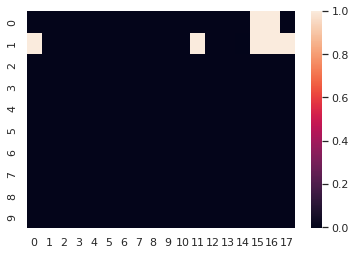

In [124]:
sns.heatmap(env.current_time_step().observation['search_tree_tokens'][0]);

<AxesSubplot:>

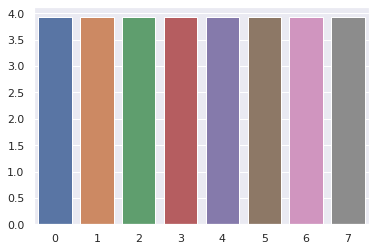

In [125]:
ts = env.current_time_step()
q_vals, *_ = agent._q_network(ts.observation['search_tree_tokens'])
q_vals = q_vals.numpy()[0][ts.observation['valid_action_mask'][0] == 1]

sns.barplot(x=list(range(q_vals.size)), y=q_vals)

In [126]:
q_vals

array([3.9273608, 3.9224896, 3.9224858, 3.9225004, 3.9226499, 3.9225357,
       3.9224448, 3.922808 ], dtype=float32)

In [134]:
q_net.layers[0].save_weights('q_net.h5')